In [1]:
using LinearAlgebra
using Turing
using LimberJack

In [2]:
function CC()
    z = [
        0.07, 0.09, 0.12, 0.17, 0.179, 0.199, 0.2,
        0.27, 0.28, 0.352, 0.38, 0.3802, 0.4,
        0.4004, 0.4247, 0.44, 0.4497, 0.47, 0.4783,
        0.48, 0.51, 0.593, 0.6, 0.61, 0.68, 0.73,
        0.781, 0.875, 0.88, 0.9, 1.037, 1.3,
        1.363, 1.43, 1.53, 1.75, 1.965
    ]

    data = [
        69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9,
        77.0, 88.8, 83.0, 81.5, 83.0, 95.0, 77.0,
        87.1, 82.6, 92.8, 89.0, 80.9, 97.0, 90.4,
        104.0, 87.9, 97.3, 92.0, 97.3, 105.0,
        125.0, 90.0, 117.0, 154.0, 168.0, 160.0,
        177.0, 140.0, 202.0, 186.5
    ]

    err = [
        19.6, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6,
        14.0, 36.6, 14.0, 1.9, 13.5, 17.0, 10.2,
        11.2, 7.8, 12.9, 23.0, 9.0, 62.0, 1.9,
        13.0, 6.1, 2.1, 8.0, 7.0, 12.0, 17.0,
        40.0, 23.0, 20.0, 17.0, 33.6, 18.0,
        14.0, 40.0, 50.4
    ]

    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end

    return (
        data_name = "CC",
        z = z,
        data = data,
        cov = cov
    )
end


CC (generic function with 1 method)

In [3]:
function BOSSDR12()
    z = [0.38, 0.51, 0.61]
    data = [81.2087, 90.9029, 98.9647]
    cov = [5.00049e+02 2.94536e+02 1.42011e+02; 2.94536e+02 7.02299e+02 4.32750e+02; 1.42011e+02 4.32750e+02 1.01718e+03]
    return (data_name = "BOSSDR12", z = z, data = data, cov = cov)
end

BOSSDR12 (generic function with 1 method)

In [4]:
cc = CC();
bossdr12 = BOSSDR12();

In [5]:
data  = [bossdr12.data; cc.data];

In [6]:
cov = zeros(length(bossdr12.data)+ length(cc.data), length(bossdr12.data)+ length(cc.data));
for i in 1:length(bossdr12.data)
    for j in 1:length(bossdr12.data)
        cov[i,j] = bossdr12.cov[i,j]
    end
end

for i in 1:length(cc.data)
    for j in 1:length(cc.data)
        cov[i+length(bossdr12.data), j+length(bossdr12.data)] = cc.cov[i,j]
    end
end


In [13]:
@model function model(data)
    Ωcdm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    Ωm := Ωcdm + Ωb
    h ~ Uniform(0.60, 0.82)
    zs = [bossdr12.z; cc.z]
    cpar = CosmoPar(Ωm= Ωm,  Ωb=Ωb, h=h)
    theory = cpar.h*100*Ez(cpar, zs)
    data ~ MvNormal(theory, cov)
end

model (generic function with 2 methods)

In [14]:
# Condition model on data
cond_model = model(data)

DynamicPPL.Model{typeof(model), (:data,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(model, (data = [81.2087, 90.9029, 98.9647, 69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9  …  125.0, 90.0, 117.0, 154.0, 168.0, 160.0, 177.0, 140.0, 202.0, 186.5],), NamedTuple(), DynamicPPL.DefaultContext())

In [15]:
# Sample model 
iterations = 500
chain = sample(cond_model, NUTS(100, 0.65, init_ϵ=0.1, max_depth=8), iterations) 

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (500×16×1 Array{Float64, 3}):

Iterations        = 101:1:600
Number of chains  = 1
Samples per chain = 500
Wall duration     = 12.39 seconds
Compute duration  = 12.39 seconds
parameters        = Ωcdm, Ωb, Ωm, h
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        Ωcdm    0.2964    0.0522    0.0034   207.5567   139.1259    1.0022     ⋯
          Ωb    0.0468    0.0106    0.0009   115.1051   127.2105    1.0026     ⋯
          Ωm    0.3432    0.0516    0.0032   231.1921   195.1343    1.0036     ⋯
           h    0.6648    0.0229    0.0015   242.1772   246.6355    1.0068     ⋯
                                                            

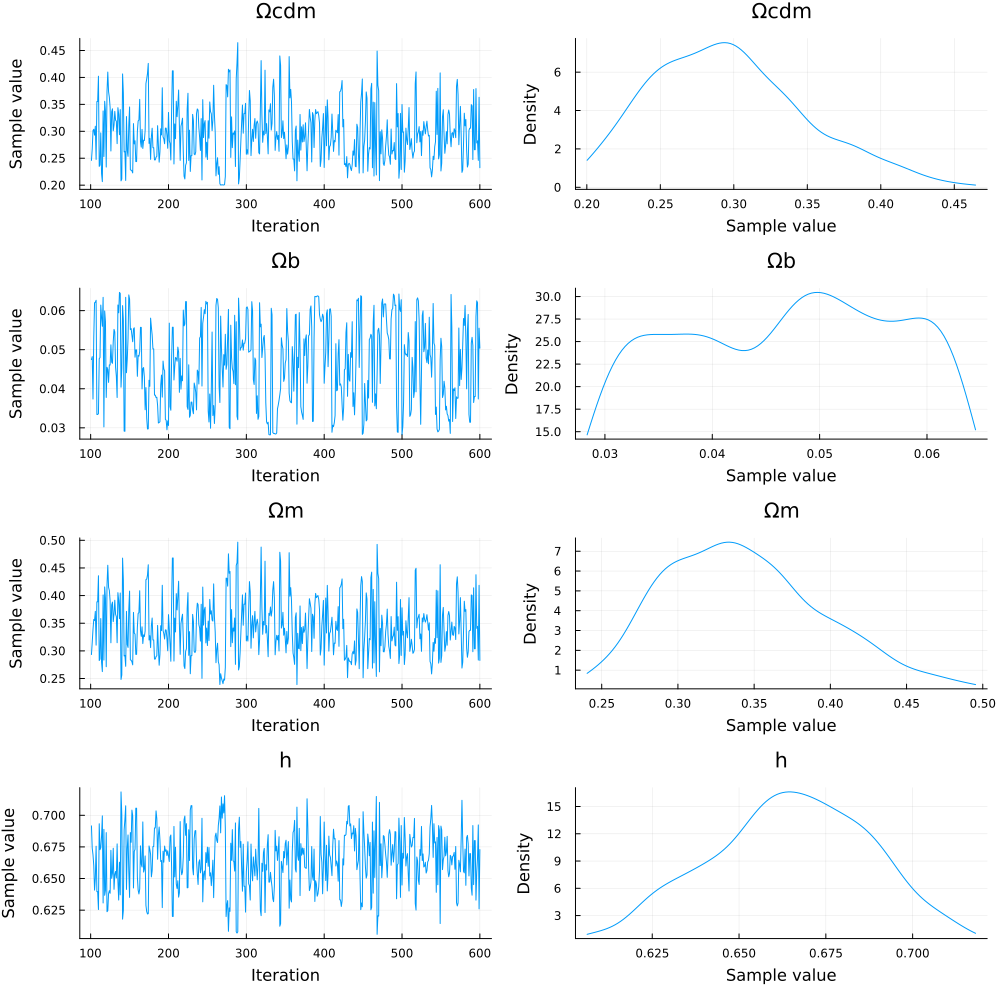

In [18]:
using StatsPlots
using MCMCChains

plot(chain)